In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import datetime
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error

c:\Users\AlexandreCastanie\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Récupération des données

Sous profil

In [3]:
def recuperation_df(sp): #sp = sous profil
    gen=pd.read_csv("coefficients-des-profils.csv",sep=";",usecols=["HORODATE","SOUS_PROFIL",
    "COEFFICIENT_PREPARE","COEFFICIENT_AJUSTE","COEFFICIENT_DYNAMIQUE"],chunksize=90000)

    df=pd.concat((x.query(f"SOUS_PROFIL == '{sp}'") for x in gen), ignore_index=True)
    df=df.set_index('HORODATE')
    df.index=pd.to_datetime(df.index,utc=True).map(lambda x: x.tz_convert('Europe/Paris'))
    return df

In [4]:
sous_profils=['PRO1_BASE','RES11_BASE','PRO2_HC','PRO2_HP','PRO5_BASE','RES1_BASE','RES2_HP','RES2_HC']
CoeffsENEDIS_PRO1=recuperation_df(sous_profils[0])
CoeffsPRO1=CoeffsENEDIS_PRO1.dropna()

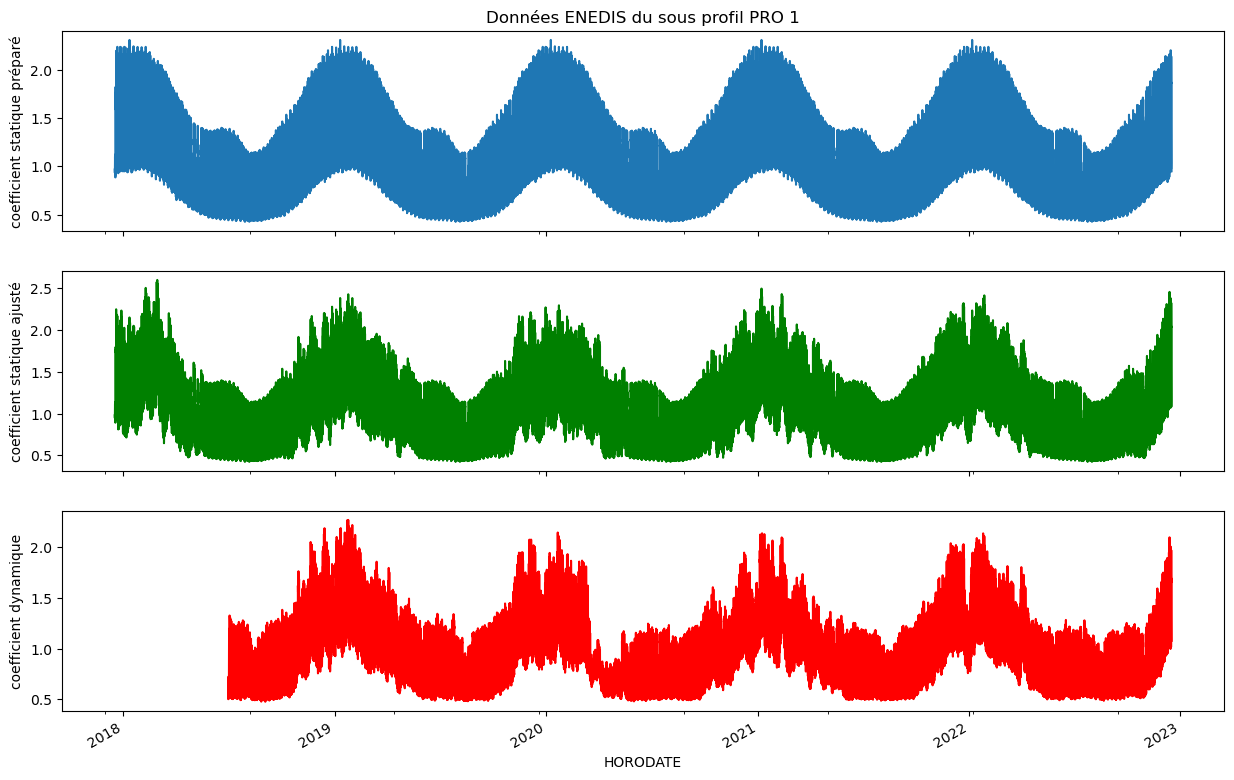

In [5]:
fig,axs=plt.subplots(3,1,figsize=(15,10),sharex=True)
CoeffsENEDIS_PRO1["COEFFICIENT_PREPARE"].plot(ax=axs[0],title="Données ENEDIS du sous profil PRO 1",ylabel="coefficient statique préparé")
CoeffsENEDIS_PRO1["COEFFICIENT_AJUSTE"].plot(ax=axs[1],color='g',ylabel='coefficient statique ajusté')
CoeffsENEDIS_PRO1["COEFFICIENT_DYNAMIQUE"].plot(ax=axs[2],color='r', ylabel='coefficient dynamique')
plt.show()

In [6]:
# fig=px.scatter(CoeffsENEDIS_PRO1,y=["COEFFICIENT_PREPARE","COEFFICIENT_AJUSTE","COEFFICIENT_DYNAMIQUE"],
# title="Données ENEDIS du sous profil PRO 1")
# fig.show()

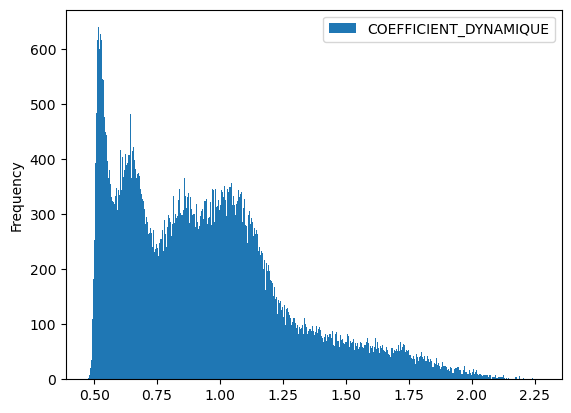

In [7]:
CoeffsPRO1['COEFFICIENT_DYNAMIQUE'].plot(kind='hist', bins=500)
plt.legend()
plt.show()

Coeffs statiques Ekwateur

In [8]:
CoeffsEk=pd.read_csv('Coefficients_statiques_ekwateur.csv',sep=';')
CoeffsEk=CoeffsEk.set_index('horodate')
CoeffsEk.index=pd.to_datetime(CoeffsEk.index,utc=True).map(lambda x: x.tz_convert('Europe/Paris'))

In [9]:
CoeffsEk.rename(columns={'PRO1-P1':'COEFFICIENT_PREPARE'},inplace=True)
Coeffsstatiques=pd.concat([CoeffsPRO1[['COEFFICIENT_PREPARE']].sort_index(),
                        CoeffsEk[['COEFFICIENT_PREPARE']].loc[CoeffsEk.index>CoeffsPRO1.index.max()].sort_index()])
Coeffsstatiques.rename(columns={'COEFFICIENT_PREPARE':'Coefficients statiques (prepare)'},inplace=True)

In [10]:
#fig=px.scatter(Coeffsstatiques,y=['Coefficients statiques (prepare)'])
#fig.show()

<AxesSubplot:title={'center':'Coefficients statiques utilisés par Ekwateur'}>

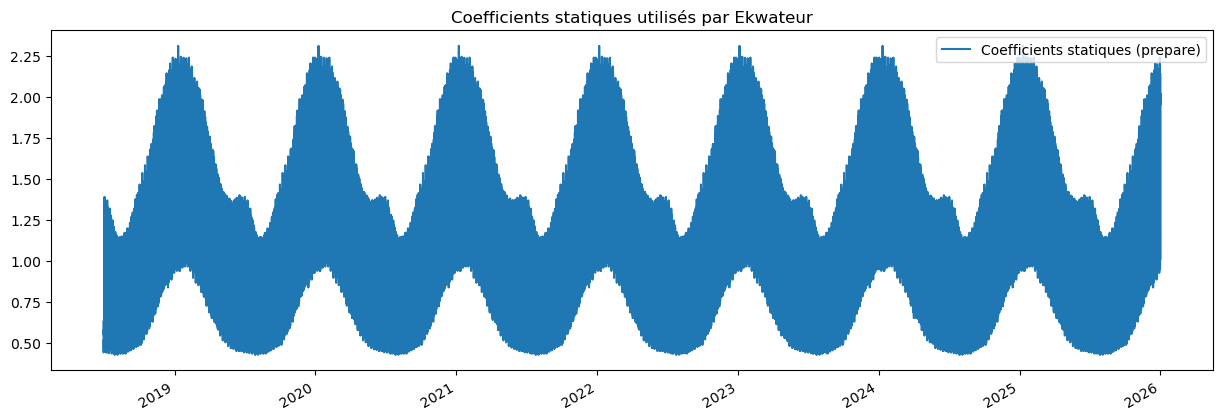

In [11]:
Coeffsstatiques.plot(figsize=(15,5),title=("Coefficients statiques utilisés par Ekwateur"))

Température

In [12]:
temperature=pd.read_csv("donnees-de-temperature-et-de-pseudo-rayonnement.csv",sep=";")
temperature=temperature.set_index('Horodate')
temperature.index=pd.to_datetime(temperature.index,utc=True)
temperature.rename(columns={'Température réalisée lissée (°C)':'Température réalisée'},inplace=True)
temperature=temperature.sort_index()

In [23]:
temperaturefuture=temperature[['Température normale lissée (°C)']].loc[(temperature.index >='2021-12-16 23:00:00') &
 (temperature.index <= '2022-12-31 23:30:00')]
temperaturefuture=temperaturefuture.sort_index()
temperaturefuture['datetime']=pd.date_range('2022-12-16 23:00:00','2023-12-31 23:30:00', freq='30min')
temperaturefuture=temperaturefuture.set_index('datetime')
temperaturefuture.index=pd.to_datetime(temperaturefuture.index,utc=True).map(lambda x: x.tz_convert('Europe/Paris'))
temptot=pd.concat([temperature[['Température normale lissée (°C)']],temperaturefuture])

<AxesSubplot:title={'center':'Température normale lissée'}>

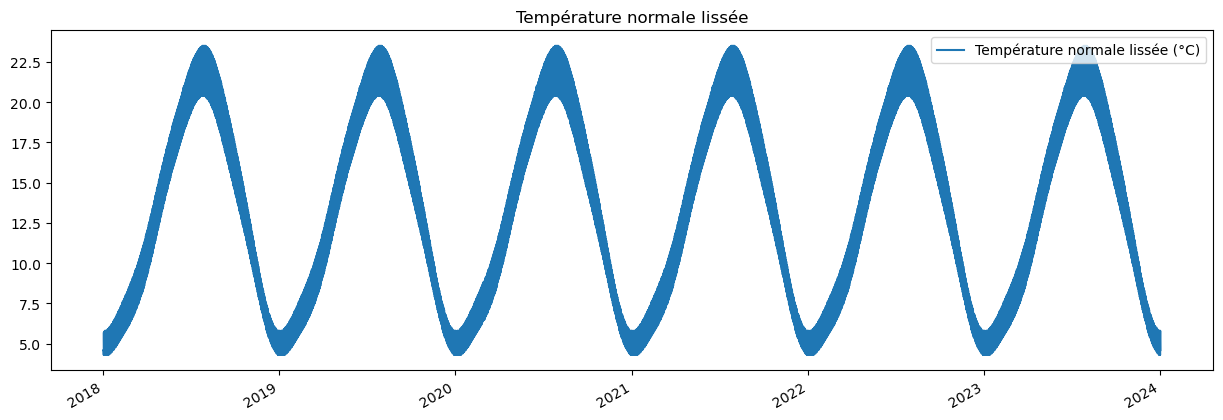

In [24]:
temptot.plot(figsize=(15,5),title="Température normale lissée")

Jours fériés

In [19]:
jf=pd.read_csv("jours_feries_metropole.csv",sep=",")
jf=jf.set_index('date')
jf.index=pd.to_datetime(jf.index,utc=True).map(lambda x: x.tz_convert('Europe/Paris'))

ifutur = pd.date_range(CoeffsPRO1.index.min(),pd.to_datetime('2024-01-01 00:00:00',utc=True).tz_convert('Europe/Paris'), freq='30min')
joursferies=pd.DataFrame(index=ifutur)
joursferies=joursferies.merge(jf,how='left',right_index=True, left_index=True)

In [20]:
def remplissage_jours_feries(df):
    for i in jf.index:
        df.loc[(df.index>=i)&
        (df.index<i+pd.Timedelta(hours=24)),'nom_jour_ferie']=1 
    df=df.fillna(0)
    return df

In [21]:
joursferies=remplissage_jours_feries(joursferies)
joursferies.rename(columns={'nom_jour_ferie':'jours fériés'},inplace=True)

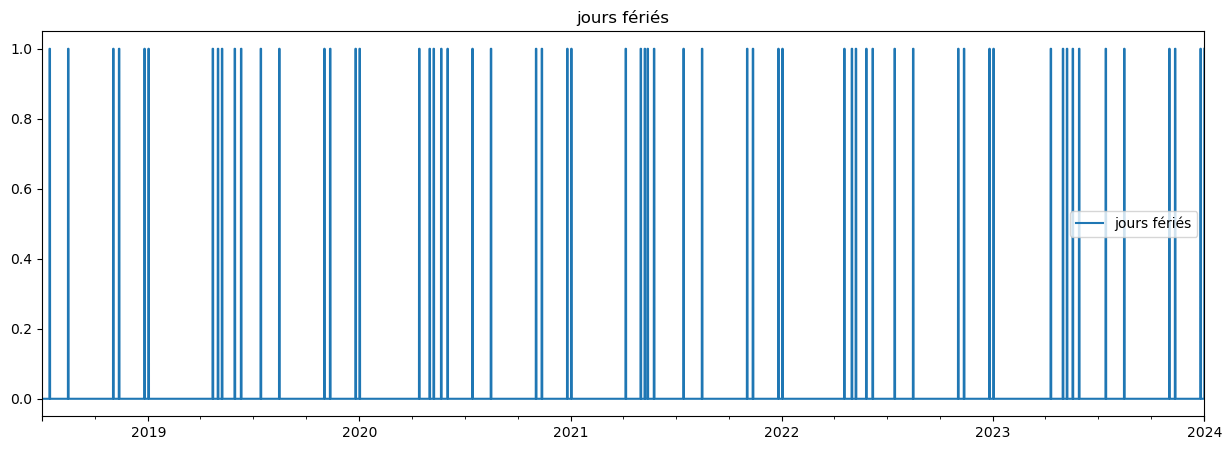

In [22]:
joursferies.plot(y=['jours fériés'],figsize=(15,5),title='jours fériés')
plt.show()

#### Cross validation principe

In [ ]:
tss = TimeSeriesSplit(n_splits=4, test_size=2*24*365*1-(48*15+1),gap=0)
CoeffsPRO1 = CoeffsPRO1.sort_index()

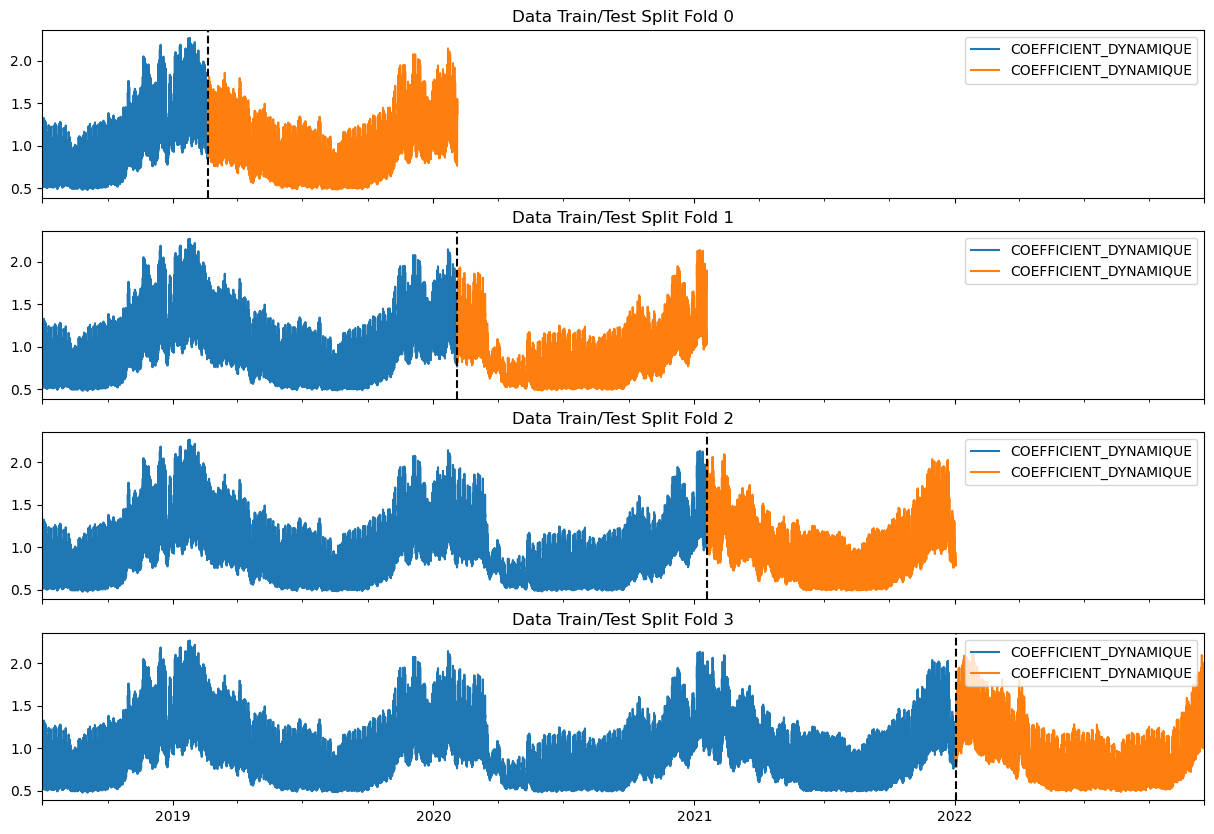

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(CoeffsPRO1):
    train = CoeffsPRO1[['COEFFICIENT_DYNAMIQUE']].iloc[train_idx]
    test = CoeffsPRO1[['COEFFICIENT_DYNAMIQUE']].iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test.plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Critères

In [25]:
def ajout_criteres(df):

    df=df.copy()
    df['minute'] = df.index.minute
    df['heure'] = df.index.hour
    df['jourdelasemaine'] = df.index.dayofweek
    df['trimestre'] = df.index.quarter
    df['mois'] = df.index.month
    df['annee'] = df.index.year
    df['jourdelannee'] = df.index.dayofyear
    df['jourdumois'] = df.index.day
    try:
        del df['jours fériés']
        del df['Température réalisée']
        del df['Température normale lissée (°C)']
        del df['Coefficients statiques (prepare)']
    except:
        pass
    df = df.merge(joursferies[['jours fériés']],how='left', left_index=True, right_index=True)
    df = df.merge(temperature[['Température réalisée']],how='left', left_index=True, right_index=True)
    df = df.merge(temptot[['Température normale lissée (°C)']],how='left', left_index=True, right_index=True)
    df = df.merge(Coeffsstatiques[['Coefficients statiques (prepare)']],how='left', left_index=True, right_index=True)

    return df

In [26]:
def add_lags(df):
    target_map = df['COEFFICIENT_DYNAMIQUE'].to_dict()
    try:
        del df['lag1']
        del df['lag2']
        del df['lag3']
    except:
        pass
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [27]:
CoeffsPRO1=add_lags(CoeffsPRO1)

C:\Users\AlexandreCastanie\AppData\Local\Temp\ipykernel_22144\2762185336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
C:\Users\AlexandreCastanie\AppData\Local\Temp\ipykernel_22144\2762185336.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
C:\Users\AlexandreCastanie\AppData\Local\Temp\ipykernel_22144\2762185336.py:11: SettingWithCopyWarning: 
A value is trying to b

### Training avec cross validation

In [28]:
CRITERES = ['jourdelannee','jourdumois', 'heure', 'jourdelasemaine','trimestre',
            'mois', 'annee','minute', 'Température réalisée', 'jours fériés', 'Température normale lissée (°C)',
            'Coefficients statiques (prepare)',
            'lag1', 'lag2', 'lag3'
            ]
CIBLE = 'COEFFICIENT_DYNAMIQUE'

In [139]:
params =  {
  "objective"           : "reg:squarederror",
  #"eval_metric"         : "rmse",
  "eta"                 : 0.5,
  "max_depth"           : 14,
  "min_child_weight"    : 0,
  #"max_delta_step"      : 1000,
  "gamma"               : 0.0,
  "subsample"           : 1,
  "sampling_method"     :'uniform',
  "colsample_bytree"    : 1,
  "reg_alpha"           : 0,
  "reg_lambda"          : 1,
  'tree_method'         : 'hist',
  'base_score'          : 1,
  #'early_stopping_rounds' : 50,
  'booster'             : 'gbtree',
  #'n_estimators'        : 400
}

In [86]:
traincv = CoeffsPRO1[["COEFFICIENT_DYNAMIQUE"]]
testcv = CoeffsPRO1[["COEFFICIENT_DYNAMIQUE"]]
traincv=ajout_criteres(traincv)
testcv = ajout_criteres(testcv)
traincv=add_lags(traincv)
testcv=add_lags(testcv)
X_traincv = traincv[CRITERES]
y_traincv = traincv[CIBLE]
dtrain=xgb.DMatrix(X_traincv,label=y_traincv)

In [140]:
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=4,
                    num_boost_round=8, metrics="rmse", 
                    as_pandas=True, 
                    #seed=20
                    )

print('RMSE: %.8f' % cv_results['test-rmse-mean'].min())

RMSE: 0.02814475


Optimisation des hyperparmètres

In [ ]:
Gridparams =  {
  #"objective"           : "reg:squarederror",
  #"eval_metric"         : "rmse",
  "eta"                 : [0.01,0.2,0.3,0.5,0.6],
  "max_depth"           : [6,8,9,10],
  #"min_child_weight"    : 0,
  #"max_delta_step"      : 1000,
  #"gamma"               : 0.0,
  "subsample"           : np.arange(0.5, 1.0, 0.1),
  #"sampling_method"     :'uniform',
  "colsample_bytree"    : np.arange(0.5, 1.0, 0.1),
  #"reg_alpha"           : 0,
  #"reg_lambda"          : 0,
  #'tree_method'         : 'hist',
  'base_score'          : np.arange(0.5, 1.0, 0.1),
  #'early_stopping_rounds' : 50,
  #'booster'             : 'gbtree',
  'n_estimators'        : [400,800,1000]
}

In [ ]:
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=Gridparams,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=0)
clf.fit(X_traincv, y_traincv)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 400, 'max_depth': 10, 'eta': 0.3, 'colsample_bytree': 0.8999999999999999, 'base_score': 0.5}
Lowest RMSE:  0.08515488256853712


cross validation 2

In [155]:
tss = TimeSeriesSplit(n_splits=4, test_size=2*24*365*1-(48*15+1),gap=0)
CoeffsPRO1 = CoeffsPRO1.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(CoeffsPRO1):
    train = CoeffsPRO1[['COEFFICIENT_DYNAMIQUE','lag1','lag2','lag3']].iloc[train_idx]
    test = CoeffsPRO1[['COEFFICIENT_DYNAMIQUE','lag1','lag2','lag3']].iloc[val_idx]
    train = ajout_criteres(train)
    test = ajout_criteres(test)

    X_train = train[CRITERES]
    y_train = train[CIBLE]

    X_test = test[CRITERES]
    y_test = test[CIBLE]

    reg=xgb.XGBRegressor(objective="reg:squarederror",
                     eval_metric="rmse",
                     eta=0.5,
                     max_depth=14,
                     #min_child_weight=0,
                     #max_delta_step=0,
                     gamma=0.0,
                     subsample=1,
                     sampling_method='uniform',
                     colsample_bytree=1,
                     reg_alpha=0,
                     reg_lambda=1,
                     tree_method='hist',
                     booster='gbtree',
                     n_estimators=400,
                     base_score=1
                     )
                     
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [156]:
Rpreds=np.transpose(preds)

In [157]:
predictionscv=pd.DataFrame(Rpreds,columns=['preds cv 1','preds cv 2','preds cv 3','preds cv 4'])
predictionscv.index=X_test.index

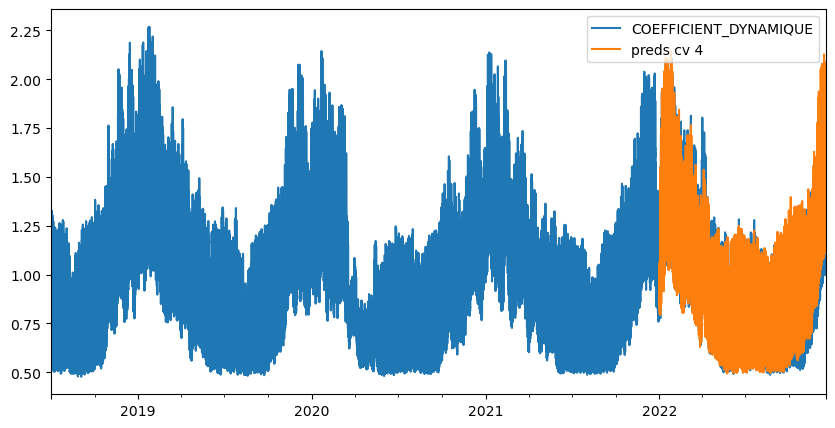

In [158]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
CoeffsPRO1[['COEFFICIENT_DYNAMIQUE']].plot(ax=ax,figsize=(10,5))
predictionscv[['preds cv 4']].plot(ax=ax)
plt.show()

In [159]:
dfcvresults=pd.merge(predictionscv,CoeffsPRO1[['COEFFICIENT_DYNAMIQUE']],how='left',right_index=True,left_index=True)

<AxesSubplot:title={'center':'comparaison des coefficients obtenus par cross validation (4th fold) et des coefficients dynamiques ENEDIS'}>

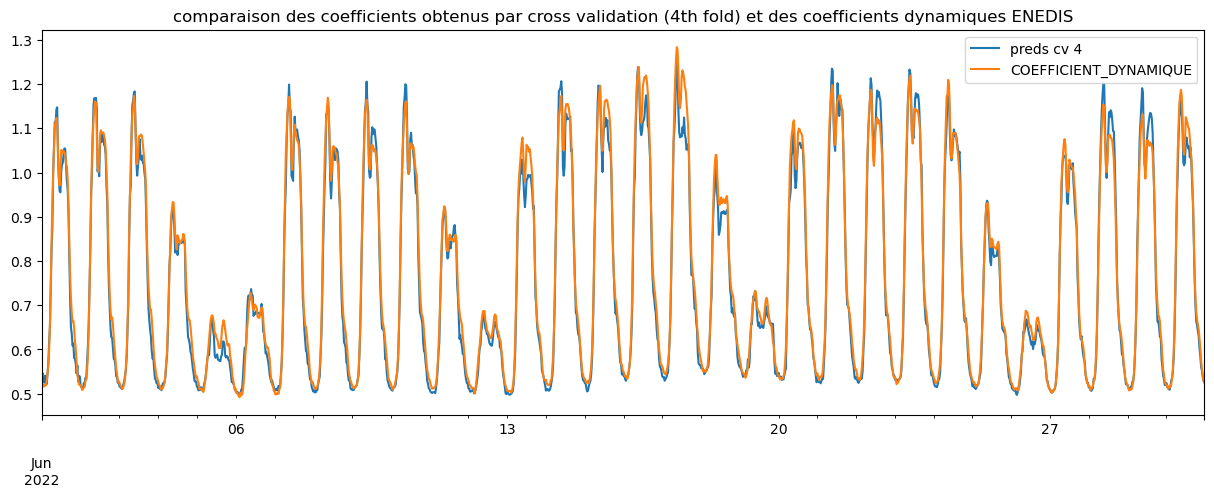

In [160]:
dfcvresults.loc[(dfcvresults.index >= '2022-06-01') 
& (dfcvresults.index < '2022-07-01')].plot(y=['preds cv 4','COEFFICIENT_DYNAMIQUE'],figsize=(15,5),
title='comparaison des coefficients obtenus par cross validation (4th fold) et des coefficients dynamiques ENEDIS')

In [161]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0917
Fold scores:[0.05937613975872695, 0.1334436258529034, 0.10241748886101402, 0.0714458031014782]


### Entrainement sur toutes les valeurs et prédiction

In [162]:
CoeffsPRO1 = ajout_criteres(CoeffsPRO1)

X_all = CoeffsPRO1[CRITERES]
y_all = CoeffsPRO1[CIBLE]

reg=xgb.XGBRegressor(objective="reg:squarederror",
                eval_metric="rmse",
                eta=0.5,
                max_depth=14,
                #min_child_weight=0,
                #max_delta_step=0,
                gamma=0.0,
                subsample=1,
                sampling_method='uniform',
                colsample_bytree=1,
                reg_alpha=0,
                reg_lambda=1,
                tree_method='hist',
                booster='gbtree',
                n_estimators=400,
                base_score=1
                )

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

y_pred = reg.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

[0]	validation_0-rmse:0.17527
[100]	validation_0-rmse:0.00152
[200]	validation_0-rmse:0.00152
[300]	validation_0-rmse:0.00152
[399]	validation_0-rmse:0.00152


In [165]:
print(f'Score {score}')
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score 0.0010404255412769755
Score across folds 0.0735
Fold scores:[0.05937613975872695, 0.1334436258529034, 0.10241748886101402, 0.0714458031014782, 0.0010404255412769755]


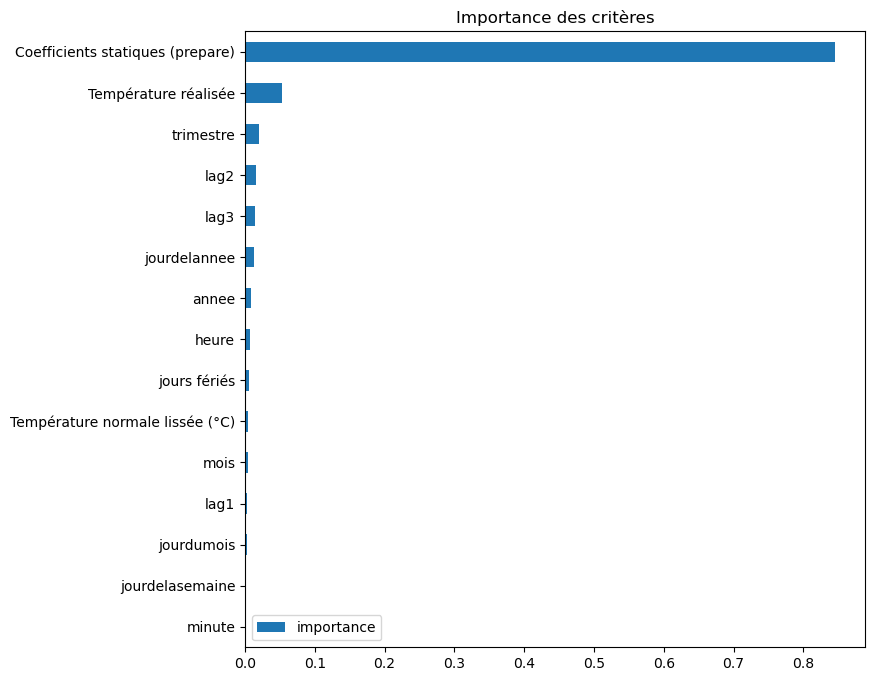

In [166]:
IC = pd.DataFrame(data=reg.feature_importances_,
             index=CRITERES,
             columns=['importance'])
IC.sort_values('importance').plot(kind='barh', title='Importance des critères',figsize=(8,8))
plt.show()

In [167]:
CoeffsPRO1.index.max()

Timestamp('2022-12-16 22:30:00+0000', tz='UTC')

In [168]:
# Create future dataframe
futur = pd.date_range('2022-12-16 23:00:00','2023-12-31 23:30:00', freq='30min')
futur_df = pd.DataFrame(index=futur)
futur_df['isFuture'] = True
CoeffsPRO1['isFuture'] = False
CoeffsPRO1_et_futur = pd.concat([CoeffsPRO1, futur_df])
CoeffsPRO1_et_futur.index=pd.to_datetime(CoeffsPRO1_et_futur.index,utc=True)
CoeffsPRO1_et_futur= ajout_criteres(CoeffsPRO1_et_futur)
CoeffsPRO1_et_futur = add_lags(CoeffsPRO1_et_futur)

In [169]:
DFfuturetcriteres = CoeffsPRO1_et_futur.query('isFuture').copy()

In [170]:
DFfuturetcriteres['prediction'] = reg.predict(DFfuturetcriteres[CRITERES])

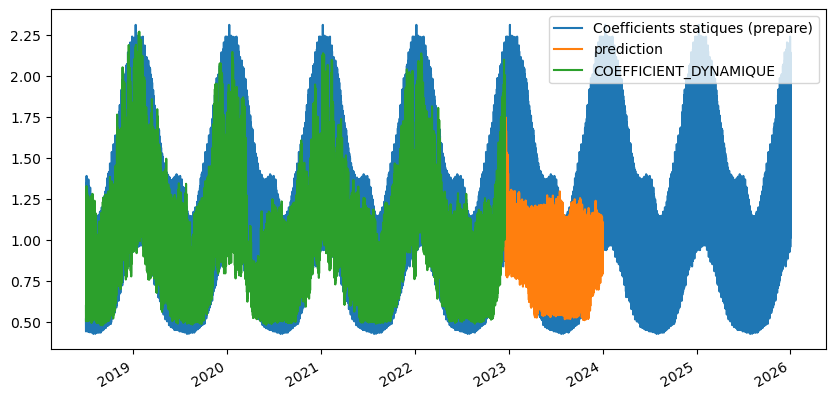

In [171]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
Coeffsstatiques.plot(ax=ax)
DFfuturetcriteres.plot(y=['prediction'],ax=ax)
CoeffsPRO1.plot(y=['COEFFICIENT_DYNAMIQUE'],ax=ax)
plt.show()

In [172]:
fig=px.line(DFfuturetcriteres,y=['prediction'])
fig.show()